# Wire Cutting Phrased as a Two-Qubit `Move` Instruction

In this tutorial, we will reconstruct expectation values of a seven-qubit circuit by splitting it into two four-qubit circuits using wire cutting.

These are the steps that we will take in this [Qiskit pattern](https://docs.quantum.ibm.com/guides/intro-to-patterns):

- **Step 1: Map problem to quantum circuits and operators**:
    - Map the hamiltonian onto a quantum circuit.
- **Step 2: Optimize for target hardware** [_Uses the cutting addon_]:
    - <font color='#0F62FE'>Cut the circuit and observable.</font>
    - Transpile the subexperiments for hardware.
- **Step 3: Execute on target hardware**:
    - Run the subexperiments obtained in Step 2 using a `Sampler` primitive.
- **Step 4: Post-process results** [_Uses the cutting addon_]:
    - <font color='#0F62FE'>Combine the results of Step 3 to reconstruct the expectation value of the observable in question.</font>

## Step 1: Map

### Create a circuit to cut

First, we begin with a circuit inspired by Fig. 1(a) of [arXiv:2302.03366v1](https://arxiv.org/abs/2302.03366v1).

In [1]:
import numpy as np
from qiskit import QuantumCircuit

qc_0 = QuantumCircuit(7)
for i in range(7):
    qc_0.rx(np.pi / 4, i)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)
qc_0.cx(3, 4)
qc_0.cx(3, 5)
qc_0.cx(3, 6)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)

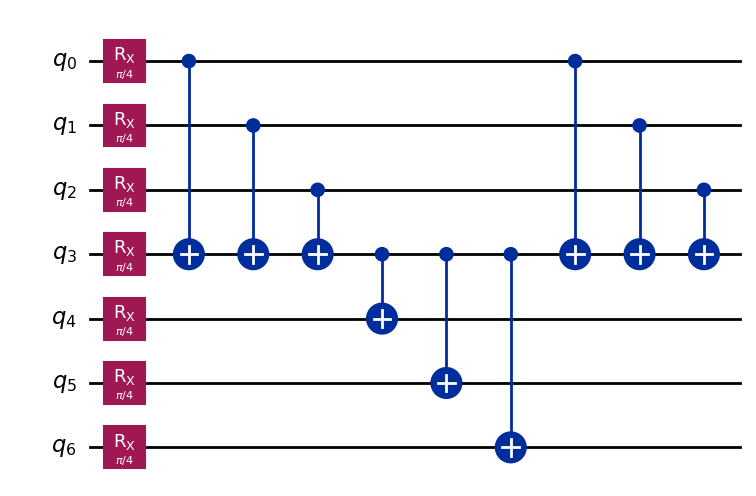

In [2]:
qc_0.draw("mpl")

### Specify an observable

In [3]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["ZIIIIII", "IIIZIII", "IIIIIIZ"])

## Step 2: Optimize

### Create a new circuit where `Move` instructions have been placed at the desired cut locations

Given the above circuit, we would like to place two wire cuts on the middle qubit line, so that the circuit can separate into two circuits of four qubits each.  One way to do this is to manually place two-qubit `Move` instructions that move the state from one qubit wire to another.  A `Move` instruction is conceptually equivalent to a reset operation on the second qubit, followed by a SWAP gate.  The effect of this instruction is to transfer the state of the first (source) qubit to the second (detination) qubit, while discarding the incoming state of the second qubit.  For this to work as intended, it is important that the second (destination) qubit share no entanglement with the remainder of the system; otherwise, the reset operation will cause the state of the remainder of the system to be partially collapsed.

Here, we build a new circuit with one additional qubit and the `Move` operations in place.  In this example, we are able to reuse a qubit: the source qubit of the first `Move` becomes the destination qubit of the second `Move` operation.

Note: As an alternative to working directly with `Move` instructions, one may choose to mark wire cuts using a single-qubit `CutWire` instruction.  The `cut_wires` function exists to transform `CutWire`s to `Move` instructions on newly allocated qubits.  However, in contrast to the manual method, this automatic method does not allow for the re-use of qubit wires.  See the `CutWire` [how-to guide](../how-tos/how_to_specify_cut_wires.ipynb) for details.

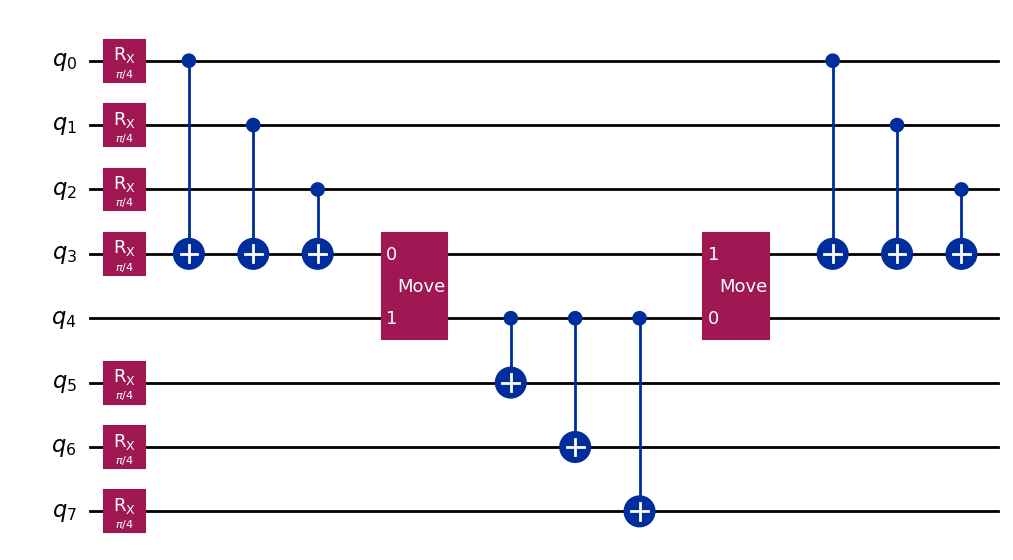

In [4]:
from qiskit_addon_cutting.instructions import Move

qc_1 = QuantumCircuit(8)
for i in [*range(4), *range(5, 8)]:
    qc_1.rx(np.pi / 4, i)
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)
qc_1.append(Move(), [3, 4])
qc_1.cx(4, 5)
qc_1.cx(4, 6)
qc_1.cx(4, 7)
qc_1.append(Move(), [4, 3])
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)

qc_1.draw("mpl")

### Create observable to go with the new circuit

This observable corresponds with `observable`, but we must account correctly for the extra qubit wire that has been added (i.e., we insert an "I" at index 4).  Note that in Qiskit, the string representation qubit-0 corresponds to the right-most Pauli character.

In [5]:
observable_expanded = SparsePauliOp(["ZIIIIIII", "IIIIZIII", "IIIIIIIZ"])

### Separate the circuit and observables

As in the previous tutorials, qubits sharing a common partition label will be grouped together, and non-local gates spanning more than one partition will be cut.

In [6]:
from qiskit_addon_cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc_1, partition_labels="AAAABBBB", observables=observable_expanded.paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

### Visualize the decomposed problem

In [7]:
subobservables

{'A': PauliList(['IIII', 'ZIII', 'IIIZ']),
 'B': PauliList(['ZIII', 'IIII', 'IIII'])}

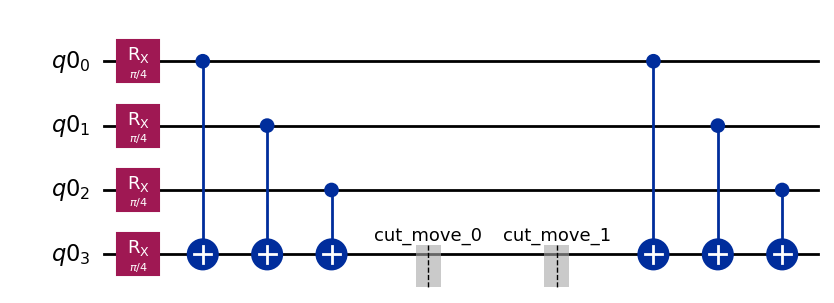

In [8]:
subcircuits["A"].draw("mpl")

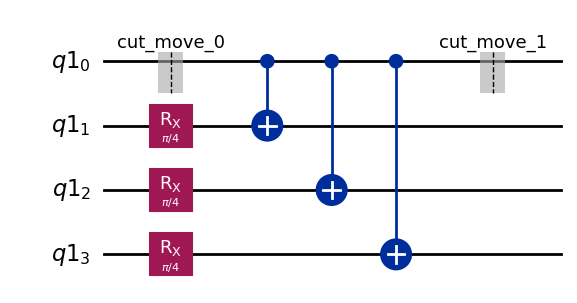

In [9]:
subcircuits["B"].draw("mpl")

### Calculate the sampling overhead for the chosen cuts

Here we cut two wires, resulting in a sampling overhead of $4^4$.

For more on the sampling overhead incurred by circuit cutting, refer to the [explanatory material](../explanation/index.rst).

In [10]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 256.0


### Generate the subexperiments to run on the backend

`generate_cutting_experiments` accepts `circuits`/`observables` args as dictionaries mapping qubit partition labels to the respective `subcircuit`/`subobservables`.

To simulate the expectation value of the full-sized circuit, many subexperiments are generated from the decomposed gates' joint quasiprobability distribution and then executed on one or more backends. The number of samples taken from the distribution is controlled by `num_samples`, and one combined coefficient is given for each unique sample. For more information on how the coefficients are calculated, refer to the [explanatory material](../explanation/index.rst).

In [11]:
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)

### Choose a backend

Here we are using a fake backend, which will result in Qiskit Runtime running in local mode (i.e., on a local simulator).

In [12]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = FakeManilaV2()

### Prepare the subexperiments for the backend

We must transpile the circuits with our backend as the target before submitting them to Qiskit Runtime.

In [13]:
from qiskit.transpiler import generate_preset_pass_manager

# Transpile the subexperiments to ISA circuits
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}

## Step 3: Execute

### Run the subexperiments using the Qiskit Runtime Sampler primitive

In [14]:
from qiskit_ibm_runtime import SamplerV2, Batch

# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }

/home/garrison/Qiskit/qiskit-ibm-runtime/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


In [15]:
# Retrieve results
results = {label: job.result() for label, job in jobs.items()}

## Step 4: Post-process

### Reconstruct the expectation value

Reconstruct expectation values for each observable term and combine them to reconstruct the expectation value for the original observable.

In [15]:
from qiskit_addon_cutting import reconstruct_expectation_values

reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)

### Compare the reconstructed expectation value with the exact expectation value from the original circuit and observable

In [16]:
from qiskit_aer.primitives import EstimatorV2

estimator = EstimatorV2()
exact_expval = estimator.run([(qc_0, observable)]).result()[0].data.evs
print(f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 1.51319069
Exact expectation value: 1.59099026
Error in estimation: -0.07779957
Relative error in estimation: -0.04890009
